# Refactoring 한 결과가 원 코드와 같은가 비교

In [1]:
import numpy as np
import soundfile as sf

import pandas as pd
import matplotlib.pyplot as plt

### Set Algorithm

In [2]:
def float_to_short(x):
    x = x*32768.0
    x[x < -32767.5] = -32768
    x[x > 32766.5] = 32767
    x = np.floor(0.5+x)
    return x

In [3]:
class Original_MDF:
    def __init__(self, fs: int, frame_size: int, filter_length: int) -> None:
        nb_mic = 1
        nb_speakers = 1
        self.K = nb_speakers
        K = self.K
        self.C = nb_mic
        C = self.C

        self.frame_size = frame_size
        self.filter_length = filter_length
        self.window_size = frame_size*2
        N = self.window_size
        self.M = int(np.fix((filter_length+frame_size-1)/frame_size))
        M = self.M
        self.cancel_count = 0
        self.sum_adapt = 0
        self.saturated = 0
        self.screwed_up = 0

        self.sampling_rate = fs
        self.spec_average = (self.frame_size)/(self.sampling_rate)
        self.beta0 = (2.0*self.frame_size)/self.sampling_rate
        self.beta_max = (.5*self.frame_size)/self.sampling_rate
        self.leak_estimate = 0

        self.e = np.zeros((N, C),)
        self.x = np.zeros((N, K),)
        self.input = np.zeros((self.frame_size, C),)
        self.y = np.zeros((N, C),)
        self.last_y = np.zeros((N, C),)
        
        self.Yf = np.zeros((self.frame_size+1, 1),)
        self.Rf = np.zeros((self.frame_size+1, 1),)
        self.Xf = np.zeros((self.frame_size+1, 1),)
        self.Yh = np.zeros((self.frame_size+1, 1),)
        self.Eh = np.zeros((self.frame_size+1, 1),)

        self.X = np.zeros((N, K, M+1), dtype=complex)
        
        self.Y = np.zeros((N, C), dtype=complex)
        self.E = np.zeros((N, C), dtype=complex)
        self.W = np.zeros((N, K, M, C), dtype=complex)
        self.foreground = np.zeros((N, K, M, C), dtype=complex)
        self.PHI = np.zeros((frame_size+1, 1),)
        self.power = np.zeros((frame_size+1, 1),)
        self.power_1 = np.ones((frame_size+1, 1),)
        self.window = np.zeros((N, 1),)
        self.prop = np.zeros((M, 1),)
        self.wtmp = np.zeros((N, 1),)
        self.window = .5-.5 * \
            np.cos(2*np.pi*(np.arange(1, N+1).reshape(-1, 1)-1)/N)
        decay = np.exp(-2.4/M)
        self.prop[0, 0] = .7
        for i in range(1, M):
            self.prop[i, 0] = self.prop[i-1, 0]*decay
        self.prop = (.8 * self.prop)/np.sum(self.prop)

        self.memX = np.zeros((K, 1),)
        self.memD = np.zeros((C, 1),)
        self.memE = np.zeros((C, 1),)
        self.preemph = .9
        if self.sampling_rate < 12000:
            self.notch_radius = .9
        elif self.sampling_rate < 24000:
            self.notch_radius = .982
        else:
            self.notch_radius = .992
        self.notch_mem = np.zeros((2*C, 1),)
        self.adapted = 0
        
        self.Pey = 1
        self.Pyy = 1
        self.Davg1 = 0
        self.Davg2 = 0
        self.Dvar1 = 0
        self.Dvar2 = 0

    def main_loop(self, u, d):
        """MDF core function

        Args:
            u (array): reference signal
            d (array): microphone signal
        """
        assert u.shape == d.shape
        u = float_to_short(u)
        d = float_to_short(d)

        e = np.zeros_like(u)
        y = np.zeros_like(u)
        end_point = len(u)

        for n in range(0, end_point, self.frame_size):
            nStep = np.floor(n/self.frame_size) + 1
            self.nStep = nStep
            # the break operation not understand.
            # only for signal channel AEC
            if n+self.frame_size > end_point:
                break
            u_frame = u[n:n+self.frame_size]
            d_frame = d[n:n+self.frame_size]
            out = self.speex_echo_cancellation_mdf(d_frame[:, None], u_frame[:, None])[:,0]
            e[n:n+self.frame_size] = out
            y[n:n+self.frame_size] = d_frame - out
        e = e/32768.0
        y = y/32768.0
        return e, y


    def speex_echo_cancellation_mdf(self, mic, far_end):
        N = self.window_size
        M = self.M
        C = self.C
        K = self.K

        Pey_cur = 1
        Pyy_cur = 1

        out = np.zeros((self.frame_size, C),)
        self.cancel_count += 1

        ss = .35/M
        ss_1 = 1 - ss

        for chan in range(C):
            # Apply a notch filter to make sure DC doesn't end up causing problems
            self.input[:, chan], self.notch_mem[:, chan] = self.filter_dc_notch16(
                mic[:, chan], self.notch_mem[:, chan])

            for i in range(self.frame_size):
                tmp32 = self.input[i, chan] - \
                    (np.dot(self.preemph, self.memD[chan]))
                self.memD[chan] = self.input[i, chan]
                self.input[i, chan] = tmp32

        for speak in range(K):
            for i in range(self.frame_size):
                self.x[i, speak] = self.x[i+self.frame_size, speak]
                tmp32 = far_end[i, speak] - \
                    np.dot(self.preemph, self.memX[speak])
                self.x[i+self.frame_size, speak] = tmp32
                self.memX[speak] = far_end[i, speak]

        # self.X = np.roll(self.X, [0, 0, 1])
        self.X = np.roll(self.X, 1, axis=2)

        for speak in range(K):
            self.X[:, speak, 0] = np.fft.fft(self.x[:, speak])/N
        
        Sxx = 0
        for speak in range(K):
            Sxx = Sxx + np.sum(self.x[self.frame_size:, speak]**2)
            self.Xf = np.abs(self.X[:self.frame_size+1, speak, 0])**2
        Sff = 0
        for chan in range(C):
            self.Y[:, chan] = 0
            for speak in range(K):
                for j in range(M):
                    self.Y[:, chan] = self.Y[:, chan] + self.X[:,
                                                               speak, j]*self.foreground[:, speak, j, chan]
            self.e[:, chan] = np.fft.ifft(self.Y[:, chan]).real * N
            self.e[:self.frame_size, chan] = self.input[:, chan] - \
                self.e[self.frame_size:, chan]
            Sff = Sff + np.sum(np.abs(self.e[:self.frame_size, chan])**2)

        if self.adapted:
            self.prop = self.mdf_adjust_prop()
        if self.saturated == 0:
            for chan in range(C):
                for speak in range(K):
                    for j in list(range(M)[::-1]):
                        self.PHI = np.concatenate([self.power_1, self.power_1[-2:0:-1]], axis=0) * self.prop[j] * np.conj(self.X[:, speak, j+1])[:,None] * self.E[:, chan][:,None]
                        self.W[:,speak,j,chan] = self.W[:,speak,j,chan]+self.PHI[:,0]

        else:
            self.saturated -= 1


        for chan in range(C):
            for speak in range(K):
                for j in range(M):
                    if j == 0 or (2+self.cancel_count) % (M-1) == j:
                        self.wtmp = np.fft.ifft(self.W[:, speak, j, chan]).real
                        self.wtmp[self.frame_size:N] = 0
                        self.W[:, speak, j, chan] = np.fft.fft(self.wtmp)

        self.Yf = np.zeros((self.frame_size+1, 1),)
        self.Rf = np.zeros((self.frame_size+1, 1),)
        self.Xf = np.zeros((self.frame_size+1, 1),)

        Dbf = 0
        for chan in range(C):
            self.Y[:, chan] = 0
            for speak in range(K):
                for j in range(M):
                    self.Y[:, chan] = self.Y[:, chan] + \
                        self.X[:, speak, j] * self.W[:, speak, j, chan]
            self.y[:, chan] = np.fft.ifft(self.Y[:, chan]).real*N

        See = 0

        for chan in range(C):
            self.e[:self.frame_size, chan] = self.e[self.frame_size:N,
                                                    chan]-self.y[self.frame_size:N, chan]

                
            Dbf = Dbf + 10 + np.sum(np.abs(self.e[:self.frame_size, chan])**2)
            self.e[:self.frame_size, chan] = self.input[:, chan] - \
                self.y[self.frame_size:N, chan]
            See = See + np.sum(np.abs(self.e[:self.frame_size, chan])**2)
        
        VAR1_UPDATE = .5
        VAR2_UPDATE = .25
        VAR_BACKTRACK = 4
        MIN_LEAK = .005

        self.Davg1 = .6*self.Davg1 + .4*(Sff-See)
        self.Dvar1 = .36*self.Dvar1 + .16*Sff*Dbf
        self.Davg2 = .85*self.Davg2 + .15*(Sff-See)
        self.Dvar2 = .7225*self.Dvar2 + .0225*Sff*Dbf

        update_foreground = 0
        if (Sff-See)*abs(Sff-See) > (Sff*Dbf):
            update_foreground = 1
        elif (self.Davg1 * abs(self.Davg1) > (VAR1_UPDATE*self.Dvar1)):
            update_foreground = 1
        elif (self.Davg2 * abs(self.Davg2) > (VAR2_UPDATE*(self.Dvar2))):
            update_foreground = 1

        if update_foreground:
            self.Davg1 = 0
            self.Davg2 = 0
            self.Dvar1 = 0
            self.Dvar2 = 0
            self.foreground = self.W
            for chan in range(C):
                self.e[self.frame_size:N, chan] = (self.window[self.frame_size:N][:,0] * self.e[self.frame_size:N, chan]) + (
                    self.window[:self.frame_size][:,0] * self.y[self.frame_size:N, chan])
        else:
            reset_background = 0
            if (-(Sff-See)*np.abs(Sff-See) > VAR_BACKTRACK*(Sff*Dbf)):
                reset_background = 1
            if ((-self.Davg1 * np.abs(self.Davg1)) > (VAR_BACKTRACK*self.Dvar1)):
                reset_background = 1
            if ((-self.Davg2 * np.abs(self.Davg2)) > (VAR_BACKTRACK*self.Dvar2)):
                reset_background = 1

            if reset_background:
                self.W = self.foreground
                for chan in range(C):

                    self.y[self.frame_size:N,
                           chan] = self.e[self.frame_size:N, chan]
                    self.e[:self.frame_size, chan] = self.input[:,
                                                                chan] - self.y[self.frame_size:N, chan]
                See = Sff
                self.Davg1 = 0
                self.Davg2 = 0
                self.Dvar1 = 0
                self.Dvar2 = 0

        Sey = 0
        Syy = 0
        Sdd = 0

        for chan in range(C):
            for i in range(self.frame_size):
                tmp_out = self.input[i, chan] - self.e[i+self.frame_size, chan]
                tmp_out = tmp_out + self.preemph * self.memE[chan]
                # This is an arbitrary test for saturation in the microphone signal
                if mic[i, chan] <= -32000 or mic[i, chan] >= 32000:
                    if self.saturated == 0:
                        self.saturated = 1
                out[i, chan] = tmp_out[0]
                self.memE[chan] = tmp_out

            self.e[self.frame_size:N, chan] = self.e[:self.frame_size, chan]
            self.e[:self.frame_size, chan] = 0
            Sey = Sey + np.sum(self.e[self.frame_size:N, chan]
                               * self.y[self.frame_size:N, chan])
            Syy = Syy + np.sum(self.y[self.frame_size:N, chan]**2)
            Sdd = Sdd + np.sum(self.input**2)

            self.E = np.fft.fft(self.e,axis=0) / N

            self.y[:self.frame_size, chan] = 0
            self.Y = np.fft.fft(self.y,axis=0) / N
            self.Rf = np.abs(self.E[:self.frame_size+1, chan])**2
            self.Yf = np.abs(self.Y[:self.frame_size+1, chan])**2
        if not (Syy >= 0 and Sxx >= 0 and See >= 0):
            self.screwed_up = self.screwed_up + 50
            out = np.zeros_like(out)
        elif Sff > Sdd + N * 10000:
            self.screwed_up = self.screwed_up + 1
        else:
            self.screwed_up = 0
        if self.screwed_up >= 50:
            print("Screwed up, full reset")
            self.__init__(self.sampling_rate,
                          self.frame_size, self.filter_length)

        See = max(See, N * 100)
        for speak in range(K):
            
            Sxx = Sxx + np.sum(self.x[self.frame_size:, speak]**2)
            self.Xf = np.abs(self.X[:self.frame_size+1, speak, 0])**2
        self.power = ss_1*self.power + 1 + ss*self.Xf[:,None]
        
        Eh_cur = self.Rf - self.Eh
        Yh_cur = self.Yf - self.Yh
        Pey_cur = Pey_cur + np.sum(Eh_cur*Yh_cur)
        Pyy_cur = Pyy_cur + np.sum(Yh_cur**2)
        
        self.Eh = (1-self.spec_average)*self.Eh + self.spec_average*self.Rf
        self.Yh = (1-self.spec_average)*self.Yh + self.spec_average*self.Yf

        Pyy = np.sqrt(Pyy_cur)
        Pey = Pey_cur/Pyy
        
        tmp32 = self.beta0*Syy
        if tmp32 > self.beta_max*See:
            tmp32 = self.beta_max*See
        alpha = tmp32 / See
        alpha_1 = 1 - alpha
        self.Pey = alpha_1*self.Pey + alpha*Pey
        self.Pyy = alpha_1*self.Pyy + alpha*Pyy

        if self.Pyy < 1:
            self.Pyy = 1
        if self.Pey < MIN_LEAK * self.Pyy:
            self.Pey = MIN_LEAK * self.Pyy
        if self.Pey > self.Pyy:
            self.Pey = self.Pyy
        self.leak_estimate = self.Pey/self.Pyy
        if self.leak_estimate > 16383:
            self.leak_estimate = 32767        
        
        RER = (.0001*Sxx + 3.*self.leak_estimate*Syy) / See
        if RER < Sey*Sey/(1+See*Syy):
            RER = Sey*Sey/(1+See*Syy)
        if RER > .5:
            RER = .5
        if (not self.adapted and self.sum_adapt > M and self.leak_estimate*Syy > .03*Syy):
            self.adapted = 1
    
        if self.adapted:
            for i in range(self.frame_size+1):
                r = self.leak_estimate*self.Yf[i]
                e = self.Rf[i]+1
                if r > .5*e:
                    r = .5*e
                r = 0.7*r + 0.3*(RER*e)
                self.power_1[i] = (r/(e*self.power[i]+10))
        else:
            adapt_rate = 0
            if Sxx > N * 1000:
                tmp32 = 0.25 * Sxx
                if tmp32 > .25*See:
                    tmp32 = .25*See
                adapt_rate = tmp32 / See
            self.power_1 = adapt_rate/(self.power+10)
            self.sum_adapt = self.sum_adapt+adapt_rate

        self.last_y[:self.frame_size] = self.last_y[self.frame_size:N]
        if self.adapted:
            self.last_y[self.frame_size:N] = mic-out
        return out

    def filter_dc_notch16(self, mic, mem):
        out = np.zeros_like(mic)
        den2 = self.notch_radius**2 + 0.7 * \
            (1-self.notch_radius)*(1 - self.notch_radius)
        for i in range(self.frame_size):
            vin = mic[i]
            vout = mem[0] + vin
            mem[0] = mem[1] + 2*(-vin + self.notch_radius*vout)
            mem[1] = vin - (den2*vout)
            out[i] = self.notch_radius * vout
        return out, mem

    def mdf_adjust_prop(self,):
        N = self.window_size
        M = self.M
        C = self.C
        K = self.K
        prop = np.zeros((M, 1),)
        for i in range(M):
            tmp = 1
            for chan in range(C):
                for speak in range(K):
                    tmp = tmp + np.sum(np.abs(self.W[:N//2+1, speak, i, chan])**2)
            prop[i] = np.sqrt(tmp)
        max_sum = np.maximum(prop, 1)
        prop = prop + .1 * max_sum
        prop_sum = 1 + np.sum(prop)
        prop = 0.99*prop/prop_sum
        return prop

In [4]:
class My_MDF:
    def __init__(self, fs: int, frame_size: int, filter_length: int) -> None: 
        self.sampling_rate = fs
        self.frame_size = frame_size
        self.filter_length = filter_length
        self.window_size = frame_size*2
        N = self.window_size
        self.MDF_blocks = int(np.fix((filter_length+frame_size-1)/frame_size))
        MDF_blocks = self.MDF_blocks
        
        # nb_mic = 1
        # nb_speakers = 1
        self.num_spk = 1
        num_spk = self.num_spk
        self.num_mic = 1
        num_mic = self.num_mic
        
        self.cancel_count = 0
        self.sum_adapt = 0
        self.saturated = 0
        self.screwed_up = 0

        self.spec_average = (self.frame_size)/(self.sampling_rate)
        self.beta0 = (2.0*self.frame_size)/self.sampling_rate
        self.beta_max = (.5*self.frame_size)/self.sampling_rate
        self.leak_estimate = 0        
        #-----------------------------------------------------------------------
        self.e = np.zeros((N, num_mic),)
        self.x = np.zeros((N, num_spk),)
        self.input = np.zeros((self.frame_size, num_mic),)
        self.y = np.zeros((N, num_mic),)
        self.last_y = np.zeros((N, num_mic),)
        self.Yf = np.zeros((self.frame_size+1, 1),)
        self.Rf = np.zeros((self.frame_size+1, 1),)
        self.Xf = np.zeros((self.frame_size+1, 1),)
        self.Yh = np.zeros((self.frame_size+1, 1),)
        self.Eh = np.zeros((self.frame_size+1, 1),)

        self.X = np.zeros((N, num_spk, MDF_blocks+1), dtype=complex)
        self.Y = np.zeros((N, num_mic), dtype=complex)
        self.E = np.zeros((N, num_mic), dtype=complex)
        self.W = np.zeros((N, num_spk, MDF_blocks, num_mic), dtype=complex)
        self.foreground = np.zeros((N, num_spk, MDF_blocks, num_mic), dtype=complex)
        self.PHI = np.zeros((frame_size+1, 1),)
        self.power = np.zeros((frame_size+1, 1),)
        self.power_1 = np.ones((frame_size+1, 1),)
        self.window = np.zeros((N, 1),)
        self.prop = np.zeros((MDF_blocks, 1),)
        self.wtmp = np.zeros((N, 1),)
        self.window = .5-.5 * \
            np.cos(2*np.pi*(np.arange(1, N+1).reshape(-1, 1)-1)/N)
        decay = np.exp(-2.4/MDF_blocks)
        self.prop[0, 0] = .7
        for i in range(1, MDF_blocks):
            self.prop[i, 0] = self.prop[i-1, 0]*decay
        self.prop = (.8 * self.prop)/np.sum(self.prop)
        #-----------------------------------------------------------------------
        self.memX = np.zeros((num_spk, 1),)
        self.memD = np.zeros((num_mic, 1),) # 이전 frame의 sample값 저장
        self.memE = np.zeros((num_mic, 1),)
        self.preemph = .9                   # pre-emphasis factor
        if self.sampling_rate < 12000:
            self.notch_radius = .9
        elif self.sampling_rate < 24000:
            self.notch_radius = .982
        else:
            self.notch_radius = .992
        self.notch_mem = np.zeros((2*num_mic, 1),)
        self.adapted = 0
        self.Rey = 1
        self.Ryy = 1
        self.Davg1 = 0
        self.Davg2 = 0
        self.Dvar1 = 0
        self.Dvar2 = 0
    #-----------------------------------------------------------------------    
    def filter_dc_notch16(self, mic, mem):
        out = np.zeros_like(mic)
        den2 = self.notch_radius**2 + 0.7 * \
            (1-self.notch_radius)*(1 - self.notch_radius)
        for i in range(self.frame_size):
            vin = mic[i]
            vout = mem[0] + vin
            mem[0] = mem[1] + 2*(-vin + self.notch_radius*vout)
            mem[1] = vin - (den2*vout)
            out[i] = self.notch_radius * vout
        return out, mem

    # Multi-Delay block Frequency domain adaptive Filter
    ## Block 별 가중치 비율을 조정하는 역할
    def mdf_adjust_prop(self,):
        N = self.window_size
        M = self.MDF_blocks
        C = self.num_mic
        K = self.num_spk
        
        # Compute each block's weight
        prop = np.zeros((M, 1),)
        for i in range(M):
            tmp = 1
            for chan in range(C):
                for speak in range(K):
                    tmp = tmp + np.sum(np.abs(self.W[:N//2+1, speak, i, chan])**2)
            prop[i] = np.sqrt(tmp)
            
        # Normalize & Tuning weights
        max_sum = np.maximum(prop, 1)   # Each block's weight > 1 을 보장
        prop = prop + .1 * max_sum      # Tuning weights
        prop_sum = 1 + np.sum(prop)     
        prop = 0.99*prop/prop_sum       # Normalize weights
        return prop
    #-----------------------------------------------------------------------
    # Apply Pre-emphasis: Reinforce high freq components
    def pre_emphasis(self, num_mic, mic):
        for channel in range(num_mic):
            ## Apply a notch filter to make sure DC doesn't end up causting problems
            self.input[:, channel], self.notch_mem[:, channel] = \
                self.filter_dc_notch16(mic[:, channel], self.notch_mem[:, channel])
            
            # Reinforce Input
            ### temp = input_frame - preemphasis factor * previous frame
            for i in range(self.frame_size):
                tmp32 = self.input[i, channel] - (np.dot(self.preemph, self.memD[channel]))
                self.memD[channel] = self.input[i, channel] # save the current input frame
                self.input[i, channel] = tmp32
    #-----------------------------------------------------------------------
    # Reinforce Far-end
    def reinforce_far_end(self, num_spk, far_end):
        ## Compute power of the far-end signal
        for speaker in range(num_spk):
            for i in range(self.frame_size):
                self.x[i, speaker] = self.x[i+self.frame_size, speaker]  # shift the far-end signal
                
                tmp32 = far_end[i, speaker] - (np.dot(self.preemph, self.memX[speaker]))
                self.x[i+self.frame_size, speaker] = tmp32
                self.memX[speaker] = far_end[i, speaker] # save the current far-end frame
    #-----------------------------------------------------------------------
    # Calculate frequency domain signals and compute energy metrics
    def calculate_freq_domain_signal(self, num_mic, num_spk, MDF_blocks, N):       
        self.Vxx = 0 
        for speaker in range(num_spk):
            self.X[:, speaker, 0] = np.fft.fft(self.x[:, speaker])/N
            self.Vxx += np.sum(self.x[self.frame_size:, speaker]**2)
        self.Vff = 0
        for channel in range(num_mic):
            self.Y[:, channel] = 0
            for speaker in range(num_spk):
                # 뒷 block 부터
                for block in range(MDF_blocks):
                    self.Y[:, channel] += self.X[:, speaker, block] * self.foreground[:, speaker, block, channel]
            self.e[:, channel] = np.fft.ifft(self.Y[:, channel]).real * N
            self.e[:self.frame_size, channel] = self.input[:, channel] - self.e[self.frame_size:, channel]
            
            self.Vff += np.sum(np.abs(self.e[:self.frame_size, channel]) **2)

        if self.adapted: self.prop = self.mdf_adjust_prop()
    #-----------------------------------------------------------------------
    # Update weights & calculate PHI
    def update_weights(self, num_mic, num_spk, MDF_blocks):
        # Weight update
        if self.saturated == 0:
            for channel in range(num_mic):
                for speaker in range(num_spk):
                    for block in list(range(MDF_blocks)[::-1]):
                        power_c = np.concatenate([self.power_1, self.power_1[-2:0:-1]], axis=0)
                        prop_tmp = self.prop[block]
                        # X의 시간 지연을 기반으로 filtering 수행
                        x_conj_tmp = np.conj(self.X[:, speaker, block+1])[:, None] 
                        e_tmp = self.E[:, channel][:, None]
                        
                        self.PHI = power_c * prop_tmp * x_conj_tmp * e_tmp
                        self.W[:, speaker, block, channel] += self.PHI[:, 0]
        else:
            self.saturated -= 1
    #-----------------------------------------------------------------------
    # Enhanching adaptation of weights
    def enhance_adaptation(self, num_mic, num_spk, MDF_blocks, N):
            # weight를 time domain으로 변환 -> 조정 -> freq domain으로 변환
        for channel in range(num_mic):
            for speaker in range(num_spk):
                for block in range(MDF_blocks):
                    # 특정 블록만 선택해 계산해서 계산비용 줄임
                    if block == 0 or (2 + self.cancel_count) % (MDF_blocks -1) == block:
                        self.wtmp = np.fft.ifft(self.W[:, speaker, block, channel]).real
                        # 특정 주파수 대역의 영향을 줄이기 위해 windowing 수행
                        self.wtmp[self.frame_size:N] = 0
                        # windowing된 weight를 사용하여 freq 성분에 대한 적응성을 높임
                        self.W[:, speaker, block, channel] = np.fft.fft(self.wtmp)
    #-----------------------------------------------------------------------
    # Echo filtering & Calculate residual echo's energy(Dbf)
    def compute_echo_residual(self, num_mic, num_spk, MDF_blocks, N):
        for channel in range(num_mic):
            self.Y[:, channel] = 0
            for speaker in range(num_spk):
                for block in range(MDF_blocks):
                    self.Y[:, channel] += self.X[:, speaker, block] * self.W[:, speaker, block, channel]
            self.y[:, channel] = np.fft.ifft(self.Y[:, channel]).real * N
        
        self.Dbf = 0 # filtering 후 남아있는 echo의 energy
        self.Vee = 0
        for channel in range(num_mic):
            self.e[:self.frame_size, channel] = self.e[self.frame_size:N, channel] - self.y[self.frame_size:N, channel]

            self.Dbf += 10 + np.sum(np.abs(self.e[:self.frame_size, channel])**2)
            self.e[:self.frame_size, channel] = self.input[:, channel] - self.y[self.frame_size:N, channel]
            self.Vee += np.sum(np.abs(self.e[:self.frame_size, channel])**2)
    #-----------------------------------------------------------------------
    # Control Filter's adaptation
    def control_filter_adaptation(self, num_mic, N):
        VAR1_UPDATE = .5
        VAR2_UPDATE = .25
        VAR_BACKTRACK = 4

        self.Davg1 = .6*self.Davg1 + .4*(self.Vff-self.Vee)
        self.Dvar1 = .36*self.Dvar1 + .16*self.Vff*self.Dbf
        self.Davg2 = .85*self.Davg2 + .15*(self.Vff-self.Vee)
        self.Dvar2 = .7225*self.Dvar2 + .0225*self.Vff*self.Dbf
        
        update_foreground = 0
        if (self.Vff-self.Vee)*abs(self.Vff-self.Vee) > (self.Vff*self.Dbf):
            update_foreground = 1
        elif (self.Davg1 * abs(self.Davg1) > (VAR1_UPDATE*self.Dvar1)):
            update_foreground = 1
        elif (self.Davg2 * abs(self.Davg2) > (VAR2_UPDATE*(self.Dvar2))):
            update_foreground = 1

        if update_foreground:
            self.Davg1 = 0
            self.Davg2 = 0
            self.Dvar1 = 0
            self.Dvar2 = 0
            self.foreground = self.W
            for channel in range(num_mic):
                self.e[self.frame_size:N, channel] = (self.window[self.frame_size:N][:,0] * self.e[self.frame_size:N, channel]) + (
                    self.window[:self.frame_size][:,0] * self.y[self.frame_size:N, channel])
        else:
            reset_background = 0
            if (-(self.Vff-self.Vee)*np.abs(self.Vff-self.Vee) > VAR_BACKTRACK*(self.Vff*self.Dbf)):
                reset_background = 1
            if ((-self.Davg1 * np.abs(self.Davg1)) > (VAR_BACKTRACK*self.Dvar1)):
                reset_background = 1
            if ((-self.Davg2 * np.abs(self.Davg2)) > (VAR_BACKTRACK*self.Dvar2)):
                reset_background = 1

            if reset_background:
                self.W = self.foreground
                for channel in range(num_mic):

                    self.y[self.frame_size:N,channel] = self.e[self.frame_size:N, channel]
                    self.e[:self.frame_size, channel] = self.input[:, channel] - self.y[self.frame_size:N, channel]
                self.Vee = self.Vff
                self.Davg1 = 0
                self.Davg2 = 0
                self.Dvar1 = 0
                self.Dvar2 = 0
    #-----------------------------------------------------------------------
    # Analyze filter's performance and handle error conditions
    def evaluate_filter_perf(self, num_mic, mic, N):
        # freq domain variables
        self.Yf = np.zeros((self.frame_size+1, 1),)
        self.Rf = np.zeros((self.frame_size+1, 1),)
        self.Xf = np.zeros((self.frame_size+1, 1),)    
        
        # energy variables
        self.Vey = 0
        self.Vyy = 0
        self.Vdd = 0
        
        
        # Signal analysis in frequency domain
        for channel in range(num_mic):
            for i in range(self.frame_size):
                tmp_out = self.input[i, channel] - self.e[i+self.frame_size, channel]
                tmp_out = tmp_out + self.preemph * self.memE[channel]
                
                # Detect saturation
                if mic[i, channel] <= -32000 or mic[i, channel] >= 32000:
                    if self.saturated == 0:
                        self.saturated = 1
                self.out[i, channel] = tmp_out[0]
                self.memE[channel] = tmp_out
            
            # Update error signal for the current channel
            self.e[self.frame_size:N, channel] = self.e[:self.frame_size, channel]
            self.e[:self.frame_size, channel] = 0
            
            self.Vey += np.sum(self.e[self.frame_size:N, channel] * self.y[self.frame_size:N, channel])
            self.Vyy += np.sum(self.y[self.frame_size:N, channel]**2)
            self.Vdd += np.sum(self.input**2)
            
            self.E = np.fft.fft(self.e, axis=0) / N
            
            self.y[:self.frame_size, channel] = 0
            self.Y = np.fft.fft(self.y, axis=0) /N
            
            # Update spectrum variables
            self.Rf = np.abs(self.E[:self.frame_size+1, channel])**2
            self.Yf = np.abs(self.Y[:self.frame_size+1, channel])**2
            
        # Check and handle filter performance issues
        if not (self.Vyy >= 0 and self.Vxx >= 0 and self.Vee >= 0):
            self.screwed_up += 50
            self.out = np.zeros_like(self.out)
        elif self.Vff > self.Vdd + N*10000:
            self.screwed_up += 1
        else:
            self.screwed_up = 0
        if self.screwed_up >= 50:
            print("Screwed up, full reset")
            self.__init__(self.sampling_rate, self.frame_size, self.filter_length)
    #-----------------------------------------------------------------------
    def update_filter_params(self,num_spk, MDF_blocks, N):
        MIN_LEAK = .005
        step_size = .35/MDF_blocks
        step_size_1 = 1 - step_size
                
        Rey_cur = 1
        Ryy_cur = 1
        
        self.Vee = max(self.Vee, N * 100)
        for speaker in range(num_spk):
            self.Vxx += np.sum(self.x[self.frame_size:, speaker]**2)
            self.Xf = np.abs(self.X[:self.frame_size+1, speaker, 0])**2
        
        # Update filter power    
        self.power = step_size_1*self.power + 1 + step_size*self.Xf[:,None]
        
        # Calculate the energy-based estimates
        Rey_cur += np.sum((self.Rf - self.Eh) * (self.Yf - self.Yh))
        Ryy_cur += np.sum((self.Yf - self.Yh)**2)
        
        # Update exponential moving averages
        self.Eh = (1-self.spec_average)*self.Eh + self.spec_average*self.Rf
        self.Yh = (1-self.spec_average)*self.Yh + self.spec_average*self.Yf
        
        # Calculate current ratio estimates
        Ryy = np.sqrt(Ryy_cur)
        Rey = Rey_cur/Ryy
        
        tmp32 = self.beta0*self.Vyy
        if tmp32 > self.beta_max*self.Vee:
            tmp32 = self.beta_max*self.Vee
        alpha = tmp32 / self.Vee
        alpha_1 = 1 - alpha
        
        # Update the filter's correlations
        self.Rey = alpha_1*self.Rey + alpha*Rey
        self.Ryy = alpha_1*self.Ryy + alpha*Ryy
        if self.Ryy < 1:
            self.Ryy = 1
        if self.Rey < MIN_LEAK * self.Ryy:
            self.Rey = MIN_LEAK * self.Ryy
        if self.Rey > self.Ryy:
            self.Rey = self.Ryy
            
        self.leak_estimate = self.Rey/self.Ryy
        if self.leak_estimate > 16383:
            self.leak_estimate = 32767

        # Calculate Residual Echo Ratio (RER)
        RER = (.0001*self.Vxx + 3.*self.leak_estimate*self.Vyy) / self.Vee
        if RER < self.Vey*self.Vey/(1+self.Vee*self.Vyy):
            RER = self.Vey*self.Vey/(1+self.Vee*self.Vyy)
        if RER > .5:
            RER = .5
        if (not self.adapted and self.sum_adapt > MDF_blocks and self.leak_estimate*self.Vyy > .03*self.Vyy):
            self.adapted = 1
        return RER
    #-----------------------------------------------------------------------
    #Update the adaptation of the fself.outilter based on current RER
    def update_adaptation(self, mic, RER, N):
        if self.adapted:
            for i in range(self.frame_size+1):
                r = self.leak_estimate*self.Yf[i]
                e = self.Rf[i]+1
                if r > .5*e:
                    r = .5*e
                r = 0.7*r + 0.3*(RER*e)
                self.power_1[i] = (r/(e*self.power[i]+10))
        else:
            adapt_rate = 0
            if self.Vxx > N * 1000:
                tmp32 = 0.25 * self.Vxx
                if tmp32 > .25*self.Vee:
                    tmp32 = .25*self.Vee
                adapt_rate = tmp32 / self.Vee
            self.power_1 = adapt_rate/(self.power+10)
            self.sum_adapt = self.sum_adapt+adapt_rate

        self.last_y[:self.frame_size] = self.last_y[self.frame_size:N]
        if self.adapted:
            self.last_y[self.frame_size:N] = mic-self.out
    #-----------------------------------------------------------------------
    def speex_echo_cancellation_mdf(self, mic, far_end):
        self.Vxx = 0
        N = self.window_size
        MDF_blocks = self.MDF_blocks
        num_mic = self.num_mic
        num_spk = self.num_spk

        self.out = np.zeros((self.frame_size, num_mic),)
        self.cancel_count +=1
        
        self.pre_emphasis(num_mic, mic)
        self.reinforce_far_end(num_spk, far_end)
        self.X = np.roll(self.X, 1, axis=2) # shift the far-end signal
        #-----------------------------------------------------------------------
        self.calculate_freq_domain_signal(num_mic, num_spk, MDF_blocks, N)
        #-----------------------------------------------------------------------
        self.update_weights(num_mic, num_spk, MDF_blocks)
        #-----------------------------------------------------------------------
        self.enhance_adaptation(num_mic, num_spk, MDF_blocks, N)       
        #-----------------------------------------------------------------------
        self.compute_echo_residual(num_mic, num_spk, MDF_blocks, N)
        #-----------------------------------------------------------------------     
        self.control_filter_adaptation(num_mic, N)
        #-----------------------------------------------------------------------
        self.evaluate_filter_perf(num_mic, mic, N)
        #-----------------------------------------------------------------------
        RER = self.update_filter_params(num_spk, MDF_blocks, N)
        self.RER_arr.append(RER)##################################################################
        #-----------------------------------------------------------------------
        self.update_adaptation(mic, RER, N)
            
        return self.out
    
    def main_loop(self, ref, mic):
        assert ref.shape == mic.shape
        ref = float_to_short(ref) # Why??
        mic = float_to_short(mic)

        e = np.zeros_like(ref)
        y = np.zeros_like(ref)
        end_point = len(ref)

        ##################################################################
        ##################################################################
        self.RER_arr = [] ################################################
        ##################################################################
        ##################################################################
        
        for n in range(0, end_point, self.frame_size):
            # only for signal channel AEC
            if n+self.frame_size > end_point:
                break
            ref_frame = ref[n:n+self.frame_size]
            mic_frame = mic[n:n+self.frame_size]
            out = self.speex_echo_cancellation_mdf(mic_frame[:, None], ref_frame[:, None])[:,0]
            e[n:n+self.frame_size] = out
            y[n:n+self.frame_size] = mic_frame - out
        e = e/32768.0
        y = y/32768.0
        
        np.savetxt('RER_mine.csv', self.RER_arr, delimiter=',', fmt='%f')

        return e, y

### Set metric

In [17]:
def calculate_erle_real(mic_input, estimated_echo):
    mic_power = np.mean(mic_input**2)
    error_power = np.mean((mic_input-estimated_echo)**2)
    
    # Calculate ERLE in dB
    erle = 10 * np.log10(mic_power / error_power)
    
    return erle

def calculate_erle_simulation(echo, estimated_echo):
    mic_power = np.mean(echo**2)
    error_power = np.mean((echo-estimated_echo)**2)
    
    # Calculate ERLE in dB
    erle = 10 * np.log10(mic_power / error_power)
    
    return erle
    
def windowed_calculate_erle(mic_input, estimated_echo, window_size=1024):
    if len(mic_input) != len(estimated_echo):
        raise ValueError("Mic input and estimated echo must have the same length.")
    
    erle_arr = []
    
    for i in range(0, len(mic_input)-window_size, window_size):
        mic_power = np.mean(mic_input[i : i+window_size]**2)
        error_power = np.mean((mic_input[i : i+window_size]-estimated_echo[i : i+window_size])**2)
        # Calculate ERLE in dB
        erle_arr.append(10 * np.log10(mic_power / error_power))   

    return np.array(erle_arr)

# ref, mic must be 1-d arr
def run_AEC(ref, mic, fs, processor, frame_size=128, filter_length=1024, output_filename=None):
    default_path = '../data/Output/'
    processor = processor(fs, frame_size, filter_length)
    aec_speech, aec_echo = processor.main_loop(ref, mic)

    # noise or signal / AEC method / used data / No.
    sf.write(default_path + "s_" + output_filename + ".wav", aec_speech, fs)
    sf.write(default_path + "n_" + output_filename + ".wav", aec_echo, fs)
    
    return aec_speech, aec_echo

### Data
- Vaccum

In [7]:
temp, sr = sf.read("../data/Vaccum/input.wav")

mic = temp[:, 0]
ref = temp[:, 2]

In [8]:
aec_speech, aec_echo_o = run_AEC(ref, mic, sr, processor=Original_MDF,output_filename="origin_rir")
aec_speech, aec_echo_m = run_AEC(ref, mic, sr, processor=My_MDF,output_filename="mine_vaccum")

calculate_erle_real(mic, aec_echo_m), calculate_erle_real(mic, aec_echo_o)

(1.5394695360832997, 1.5394695360832997)

In [9]:
# Difference
np.sum(aec_echo_m - aec_echo_o)

0.0

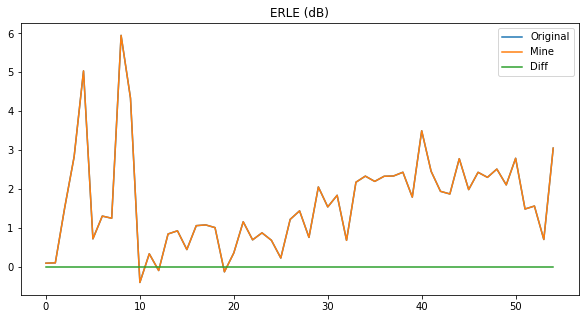

In [12]:
# ERLE graph

win_erle_o = windowed_calculate_erle(mic, aec_echo_o)
win_erle_m = windowed_calculate_erle(mic, aec_echo_m)

plt.figure(figsize=(10, 5))
plt.plot(win_erle_o, label="Original")
plt.plot(win_erle_m, label="Mine")
plt.plot(win_erle_o - win_erle_m, label="Diff")
plt.legend()
plt.title("ERLE (dB)")
plt.show()

- RIR mixing

In [18]:
mic, sr = sf.read("../data/Mixing/RIR_mixed.wav")
ref, sr = sf.read("../data/Mixing/RIR_echo.wav")
gt_speech, sr = sf.read("../data/Mixing/RIR_speech.wav")
gt_ref, sr = sf.read("../data/Mixing/echo.wav")

mic = mic[:, 0]
ref = ref[:, 0]

gt_speech = gt_speech[:, 0] 
gt_ref = gt_ref[:]

In [20]:
aec_speech, aec_echo_o = run_AEC(gt_ref, mic, sr, processor=My_MDF,output_filename="mine_rir")
aec_speech, aec_echo_m = run_AEC(gt_ref, mic, sr, processor=Original_MDF,output_filename="origin_rir")
calculate_erle_simulation(mic, aec_echo_o), calculate_erle_simulation(mic, aec_echo_m)

(0.8412155995645849, 0.8412155995645849)

In [21]:
# Difference
np.sum(aec_echo_m - aec_echo_o)

0.0

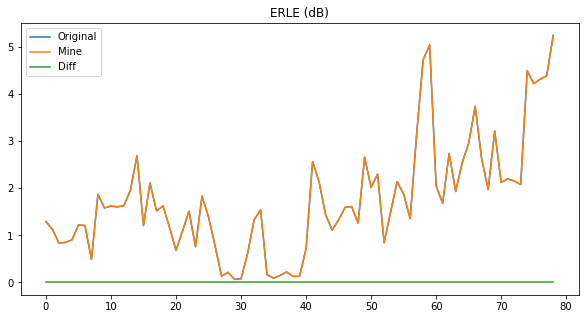

In [22]:
# ERLE graph

win_erle_o = windowed_calculate_erle(mic, aec_echo_o)
win_erle_m = windowed_calculate_erle(mic, aec_echo_m)

plt.figure(figsize=(10, 5))
plt.plot(win_erle_o, label="Original")
plt.plot(win_erle_m, label="Mine")
plt.plot(win_erle_o - win_erle_m, label="Diff")
plt.legend()
plt.title("ERLE (dB)")
plt.show()